# <font style="color: rgb(0,0,0);">Option A: </font> <font style="color: rgb(190,138,67);">ISRU efficiency</font>

In [1]:
# imports

import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
from tqdm import tqdm

from PIL import Image, ImageTk, ImageMath, ImageOps
Image.MAX_IMAGE_PIXELS = 10000000000
import PIL.ImageGrab as ImageGrab

import sys

import xarray as xr

from os import environ
environ["OPENCV_IO_ENABLE_JASPER"] = "true"
import cv2

import urllib
import os

import geopandas
import shapely
shapely.geos.geos_version
from shapely.ops import cascaded_union

# colormaps
inferno = cm.get_cmap('inferno', 256)
cividis = cm.get_cmap('cividis', 256)
bone = cm.get_cmap('bone', 256)
gray = cm.get_cmap('gray', 256)

In [2]:
# import helper functions
from helper_functions import *

# ISRU model

Model from Guerrero-Gonzalez <br>
https://doi.org/10.1016/j.actaastro.2022.11.050  

In [3]:
# input weight percent Ilmenite
# output ISRU mass for production plant - producing 23.9 t Oxygen per year

def ISRU_mass(x):

    y0 =  4036*x**-1.064  -9.59   # Excavation
    y1 = 17580*x**-1.003  -390.8  # Handling
    y2 = 19240*x**-1.003  -421.9  # Beneficiation
    y3 = 21780*x**-1.198  +120.3  # O2 Extraction
    y4 = 17910*x**-1.265  +1370   # O2 Purification
    y5 = 29650*x**-0.7005 -602.5  # Metal Processing
    y6 =  2541*x**-0.7434 +286.8  # Gas Liquefaction & Storage
    y7 = 32440*x**-0.8312 +125.2  # Thermal Control
    y8 = 12000*x**-0.9657 +63.99  # Power

    y_sum = y0 + y1 + y2 + y3 + y4 + y5 + y6 + y7 + y8 
    
    return y_sum

def ISRU_mass_without_Metall_Processing(x):

    y0 =  4036*x**-1.064  -9.59   # Excavation
    y1 = 17580*x**-1.003  -390.8  # Handling
    y2 = 19240*x**-1.003  -421.9  # Beneficiation
    y3 = 21780*x**-1.198  +120.3  # O2 Extraction
    y4 = 17910*x**-1.265  +1370   # O2 Purification

    y6 =  2541*x**-0.7434 +286.8  # Gas Liquefaction & Storage
    y7 = 32440*x**-0.8312 +125.2  # Thermal Control
    y8 = 12000*x**-0.9657 +63.99  # Power

    y_sum = y0 + y1 + y2 + y3 + y4 +      y6 + y7 + y8 
    
    return y_sum


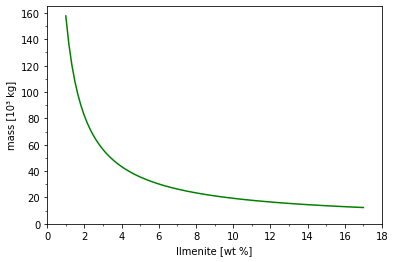

In [4]:
x = np.linspace(1,17,100)     # x goes from 1 to 17 wt.%
y = ISRU_mass(x)/(10**3)

fig, ax = plt.subplots()

ax.plot(x, y, 'g-')

ax.set_xticks(np.arange(0, max(x)+1, 1), minor=True)
ax.set_yticks(np.arange(0, max(y)+1, 10), minor=True)

ax.set_xlabel("Ilmenite [wt %]")
ax.set_ylabel("mass [10³ kg]")

ax.set_xlim(0, 18)
ax.set_ylim(0, 165)

plt.savefig("doc/img/ISRU_function.png", dpi=300)
plt.show()

In [5]:
# compare the spread with and without Metall Processing subsystem
# 1 < x < 11
total_spread = ISRU_mass(1)-ISRU_mass(11)
total_spread_wo_MP = ISRU_mass_without_Metall_Processing(1)-ISRU_mass_without_Metall_Processing(11)

spread_percentage = (total_spread * 100) / ISRU_mass(1)
spread_wo_MP_percentage = (total_spread_wo_MP * 100) / ISRU_mass_without_Metall_Processing(1)

print('spread:',spread_percentage,'%','of ISRU_mass(1)')
print('spread:',spread_wo_MP_percentage,'%','of ISRU_mass_without_Metall_Processing(1)')

spread: 88.69288763856906 % of ISRU_mass(1)
spread: 89.96790007518659 % of ISRU_mass_without_Metall_Processing(1)


## Aquire global Ilmenite map

### combine source TIF files
> WAC TiO2 Abundance Map https://doi.org/10.1016/j.icarus.2017.06.013        

download TIF: https://wms.lroc.asu.edu/lroc/view_rdr/WAC_TIO2
<br>
readme https://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/WAC_TIO2/WAC_TIO2_README.TXT
<br>
file-browser http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/BROWSE/WAC_TIO2/

In [6]:
# combine source TIF

import sys
from PIL import Image

line1_images = [Image.open(x) for x in ['sources\map\WAC_TIO2_E350N2250.TIF', 'sources\map\WAC_TIO2_E350N3150.TIF', 'sources\map\WAC_TIO2_E350N0450.TIF','sources\map\WAC_TIO2_E350N1350.TIF']]
line2_images = [Image.open(x) for x in ['sources\map\WAC_TIO2_E350S2250.TIF', 'sources\map\WAC_TIO2_E350S3150.TIF', 'sources\map\WAC_TIO2_E350S0450.TIF','sources\map\WAC_TIO2_E350S1350.TIF']]

l1_widths, l1_heights = zip(*(i.size for i in line1_images))
l2_widths, l2_heights = zip(*(i.size for i in line2_images))

print('HEIGHTS',l1_heights,l2_heights)
print('WIDTHS',l1_widths,l2_widths)

for i in range (0, len(l1_heights)-1):
    if l1_widths[i] != l1_widths[i+1]:
        print('CRITICAL WARNING     different l1_widths detected',tuple((l1_widths[i],l1_widths[i+1])))

    if l1_heights[i] != l1_heights[i+1]:
        print('CRITICAL WARNING     different l1_heights detected',tuple((l1_heights[i],l1_heights[i+1])))

for i in range (0, len(l2_heights)-1):
    if l2_widths[i] != l2_widths[i+1]:
        print('CRITICAL WARNING     different l2_widths detected',tuple((l2_widths[i],l2_widths[i+1])))

    if l2_heights[i] != l2_heights[i+1]:
        print('CRITICAL WARNING     different l2_heights detected',tuple((l2_heights[i],l2_heights[i+1])))


if sum(l1_widths) == sum(l2_widths):
    print('SUCCESS  both line widths are matching')

total_height = max(l1_heights) + max(l2_heights)
total_width = max(sum(l1_widths), sum(l2_widths))

new_im = Image.new('L', (total_width, total_height))

x_offset = 0
y_offset = 0
for im in line1_images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

x_offset = 0
y_offset = max(l1_heights)
for im in line2_images:
  new_im.paste(im, (x_offset,y_offset))
  x_offset += im.size[0]

print("saving image ...")
new_im.save('maps/preparation/TiO2/WAC_TIO2_COMBINED_RAW.png')
#new_im.save('maps/preparation/TiO2/WAC_TIO2_COMBINED_MAP_RAW.TIF')
print('done.')

HEIGHTS (5321, 5321, 5321, 5321) (5321, 5321, 5321, 5321)
WIDTHS (6840, 6840, 6841, 6840) (6840, 6840, 6841, 6840)
CRITICAL WARNING     different l1_widths detected (6840, 6841)
CRITICAL WARNING     different l1_widths detected (6841, 6840)
CRITICAL WARNING     different l2_widths detected (6840, 6841)
CRITICAL WARNING     different l2_widths detected (6841, 6840)
SUCCESS  both line widths are matching
saving image ...
done.


In [7]:
# first and last line of the combined picture are empty     - cutting them away
# empty coloum after between 3rd and 4th piece in the lines - cutting them away
# empty lines are from source TIF images

data = np.array(Image.open("maps/preparation/TiO2/WAC_TIO2_COMBINED_RAW.png"))
print("input",data.shape)

print(np.count_nonzero(data==0),"Zeros found in Picture")
    
if data [0][0] == 0:
    
    print("removing first and last line")
    crop_data = np.delete(data,(0,data.shape[0]-1), axis=0)
    print(np.count_nonzero(crop_data==0),"Zeros found in Picture")
    
    print("removing coloum between 3rd and 4th picture in line")
    crop_data = np.delete(crop_data,(int(3* (data.shape[1]/4))), axis=1)
    print(np.count_nonzero(crop_data==0),"Zeros found in Picture")
    
    print("output",crop_data.shape)
    
    print("saving image ...")
    new_im = Image.fromarray(crop_data)
    new_im.save('maps/preparation/TiO2/WAC_TIO2_COMBINED.png')
    print("done.")
    
else: print("data seems fine already")

input (10642, 27361)
65362 Zeros found in Picture
removing first and last line
10640 Zeros found in Picture
removing coloum between 3rd and 4th picture in line
0 Zeros found in Picture
output (10640, 27360)
saving image ...
done.


### plot result for paper Figure

due to bug in matplotlib on high resolution images, pdf would distord colors <br>
-> downscaling data for figure in paper

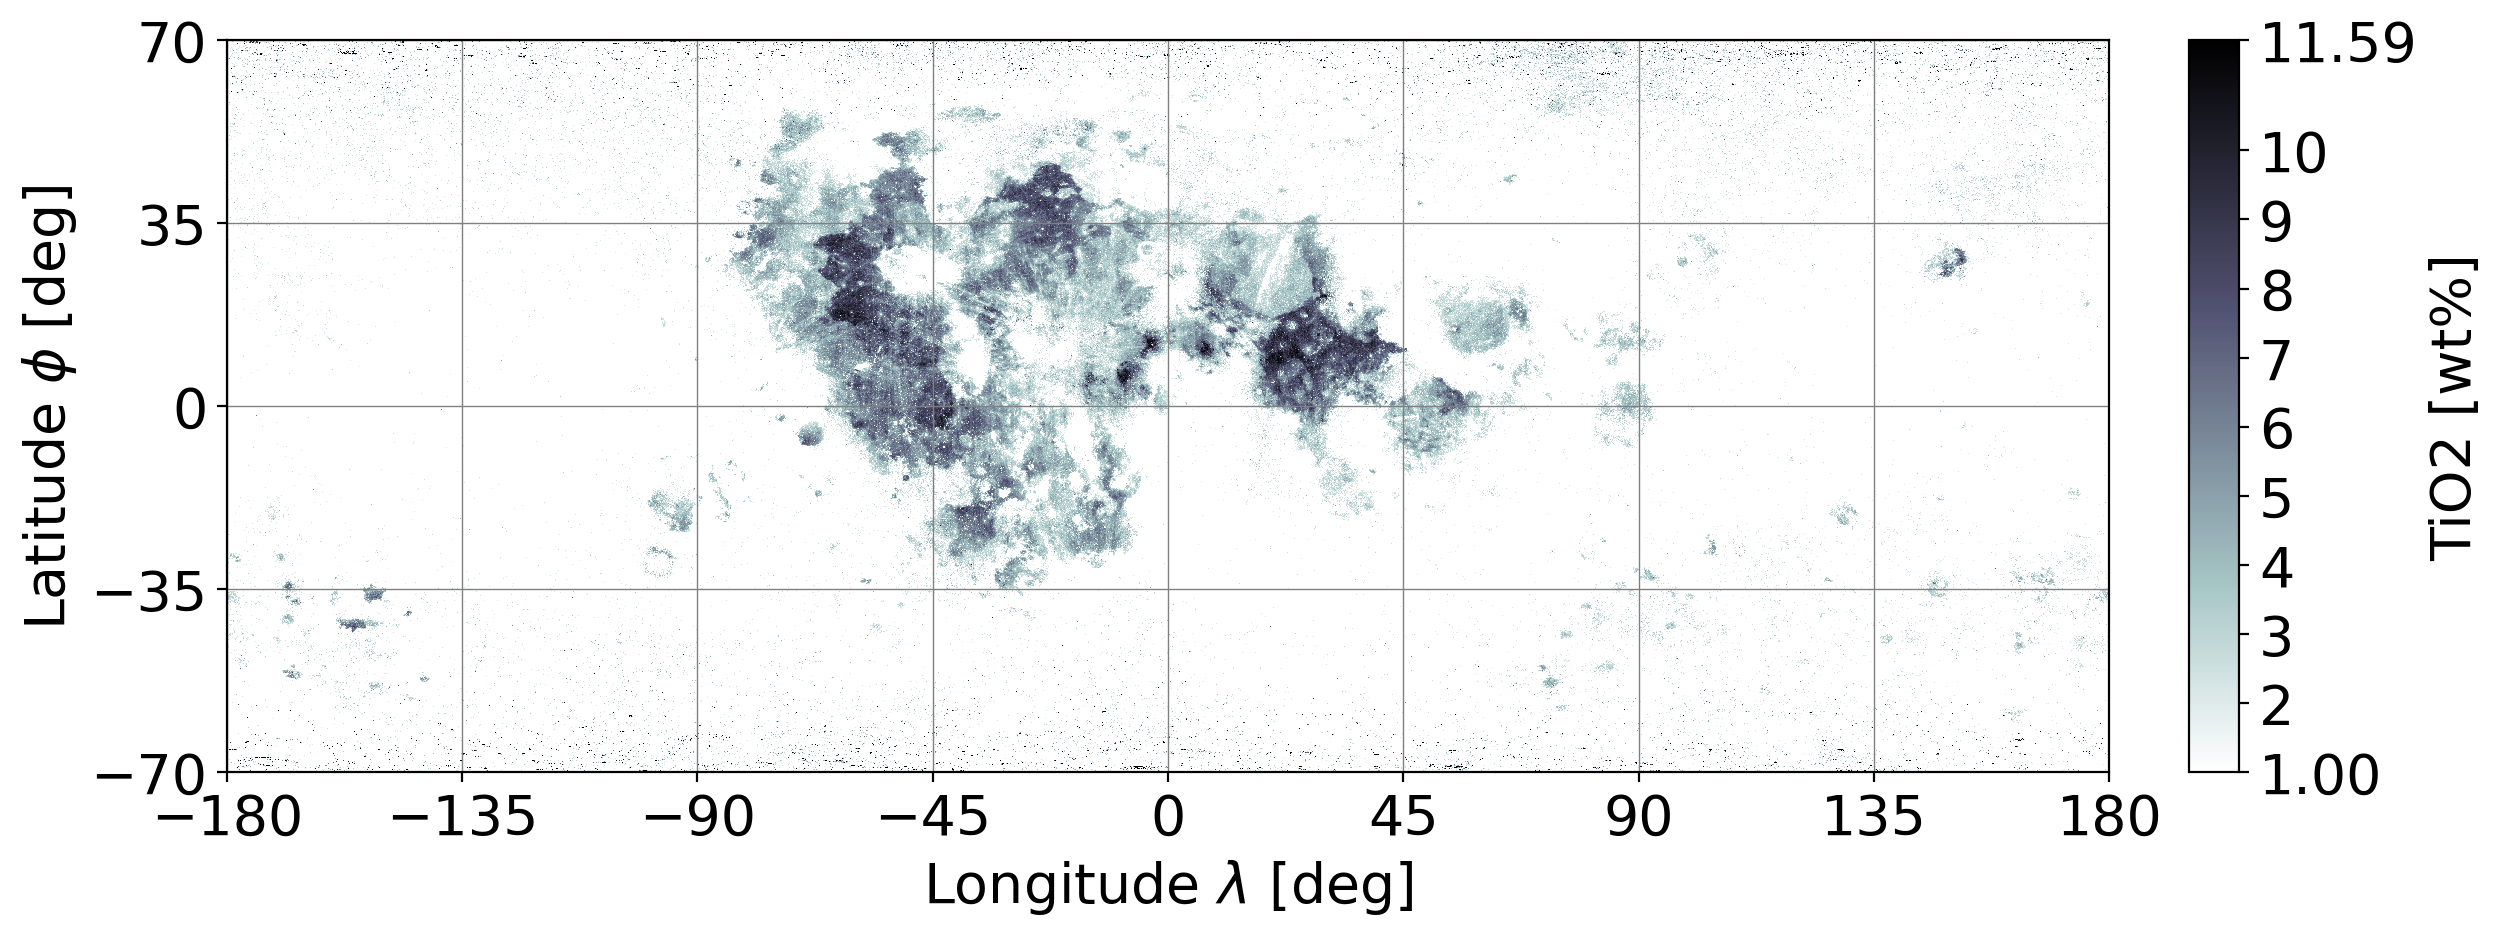

In [3]:
data = cv2.resize(np.array(Image.open("maps/preparation/TiO2/WAC_TIO2_COMBINED.png")), dsize=(5000,1944), interpolation=cv2.INTER_NEAREST)
divider = 22
plot_map(data,divider,'TiO2 [wt%]',tuple((-70,70)),tuple((-180,180)),y_limit=[-70,70],i_steps=(np.array([2,3,4,5,6,7,8,9,10])*divider).tolist(),cmap=bone.reversed(),interpolation='none',silent=True,labelsize=20,save="WAC_TIO2_COMBINED.pdf")

### loading mare boundaries mask from source, converting into BW image
> Nelson, D. M., Koeber, S. D., Daud, K., Robinson, M. S., Watters, T. R., Banks, M. E., & Williams, N. R. (2014, March). Mapping lunar maria extents and lobate scarps using LROC image products. In Lunar and Planetary Science Conference (Vol. 45, p. 2861).

download: http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/SHAPEFILE/LROC_GLOBAL_MARE/LROC_GLOBAL_MARE_180.SHP
<br>
readme:   http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/SHAPEFILE/LROC_GLOBAL_MARE/LROC_GLOBAL_MARE_README.TXT
<br>
files:     http://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/EXTRAS/SHAPEFILE/LROC_GLOBAL_MARE/

In [10]:
# open shapefile in geopandas and plot in png

import geopandas
from shapely.geometry import Point,Polygon
from shapely.ops import unary_union
from tqdm import tqdm   # progreess bar
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000
import numpy as np
import matplotlib.pyplot as plt


df = geopandas.read_file("sources\map\LROC_GLOBAL_MARE_180\LROC_GLOBAL_MARE_180.shp")
print(df)
df.plot("MARE_NAME", color="White", antialiased=False)
plt.axis('off')


print("saving ...")

# Mare map goes from 65N to 65S
# Mare (6px x 4px) per dpi
# to match (27360, 10640) -> 4560 dpi matching Longitude

# remove all whitespace padding around canvas
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('maps\preparation\TiO2\LROC_GLOBAL_MARE_180.png', dpi=4560,facecolor ='black', bbox_inches='tight',pad_inches = 0)

print("done.")
plt.close()

     ID        MARE_NAME   Perimtr_km       Area_km  \
0     1    Cognitum East  4157.317772  58602.592926   
1     0            Crger   151.939407   1312.065758   
2     0         Endymion   447.162294   6514.848991   
3     0    Mare Temporis   346.920443   1944.760025   
4     0     Schumacher B    66.471067    266.591729   
..   ..              ...          ...           ...   
639   0   Lacus Aestatis    25.427598     26.188966   
640   0          Rocca F    40.120928     63.678815   
641   0  Vasco da Gama R    38.287222     72.257063   
642   0  Vasco da Gama R    30.247695     34.644467   
643   0   Mare Orientale    17.668961     11.274133   

                                              geometry  
0    POLYGON ((-10.67021 -6.80306, -10.68354 -6.820...  
1    POLYGON ((-67.62647 -16.97267, -67.61314 -16.9...  
2    POLYGON ((54.73263 54.87587, 54.78062 54.92168...  
3    POLYGON ((57.48461 42.41091, 57.51602 42.48158...  
4    POLYGON ((59.64808 42.42007, 59.68210 42.37034...

C:\Users\svens\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


saving ...
done.


In [11]:
# adjust mask .png (65N to 65S) to WAC resolution (70N to 70S) -> extend top and bottom with 5 deg
# height: 9979 px to 10640 px

im = Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180.png").convert('L')
print("LROC_GLOBAL_MARE_180.png opened.")

width, height = im.size
print("input",im.size)
new_width, new_height = (27360,10640)
print("output",tuple((new_width, new_height)))

# extending top and bottom 
pad = round((new_height - height)/2)
shift_offset = 69 # pixel measured offset - unknown reason for shift - manually align

new_im = Image.new('L', (new_width, new_height))
x_offset = 0
y_offset = pad + shift_offset
new_im.paste(im, (x_offset,y_offset))

print("saving results...")
new_im.save('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png')

print("creating NEG version...")
im = Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png")
im_invert = ImageOps.invert(im)
print("saving results...")
im_invert.save('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK_NEG.png')
print('COMPLETED.')


LROC_GLOBAL_MARE_180.png opened.
input (27360, 9979)
output (27360, 10640)
saving results...
creating NEG version...
saving results...
COMPLETED.


Average 40.14077365494328


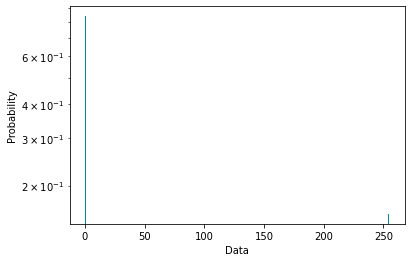

Average 214.85922634505673


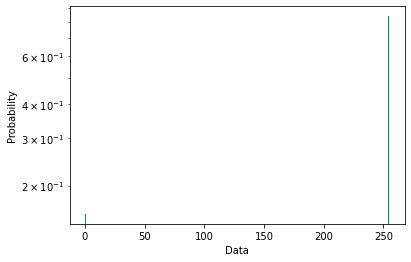

In [12]:
# test for only BW
x = np.array(Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png"))
plot_histogram(x, "darkcyan")

x = np.array(Image.open("maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK_NEG.png"))
plot_histogram(x, "darkcyan")

### applying mask to combined map, create clustering

In [13]:
# apply masking

import cv2

image = cv2.imread('maps\preparation\TiO2\WAC_TIO2_COMBINED.png',0)

mask =     cv2.imread('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png',0)
mask_neg = cv2.imread('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK_NEG.png',0)

result_mare = cv2.bitwise_and(image, mask)
result_high = cv2.bitwise_and(image, mask_neg)

cv2.imwrite('maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_MARE.png', result_mare)
cv2.imwrite('maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_HIGH.png', result_high)

print('COMPLETED.')

COMPLETED.


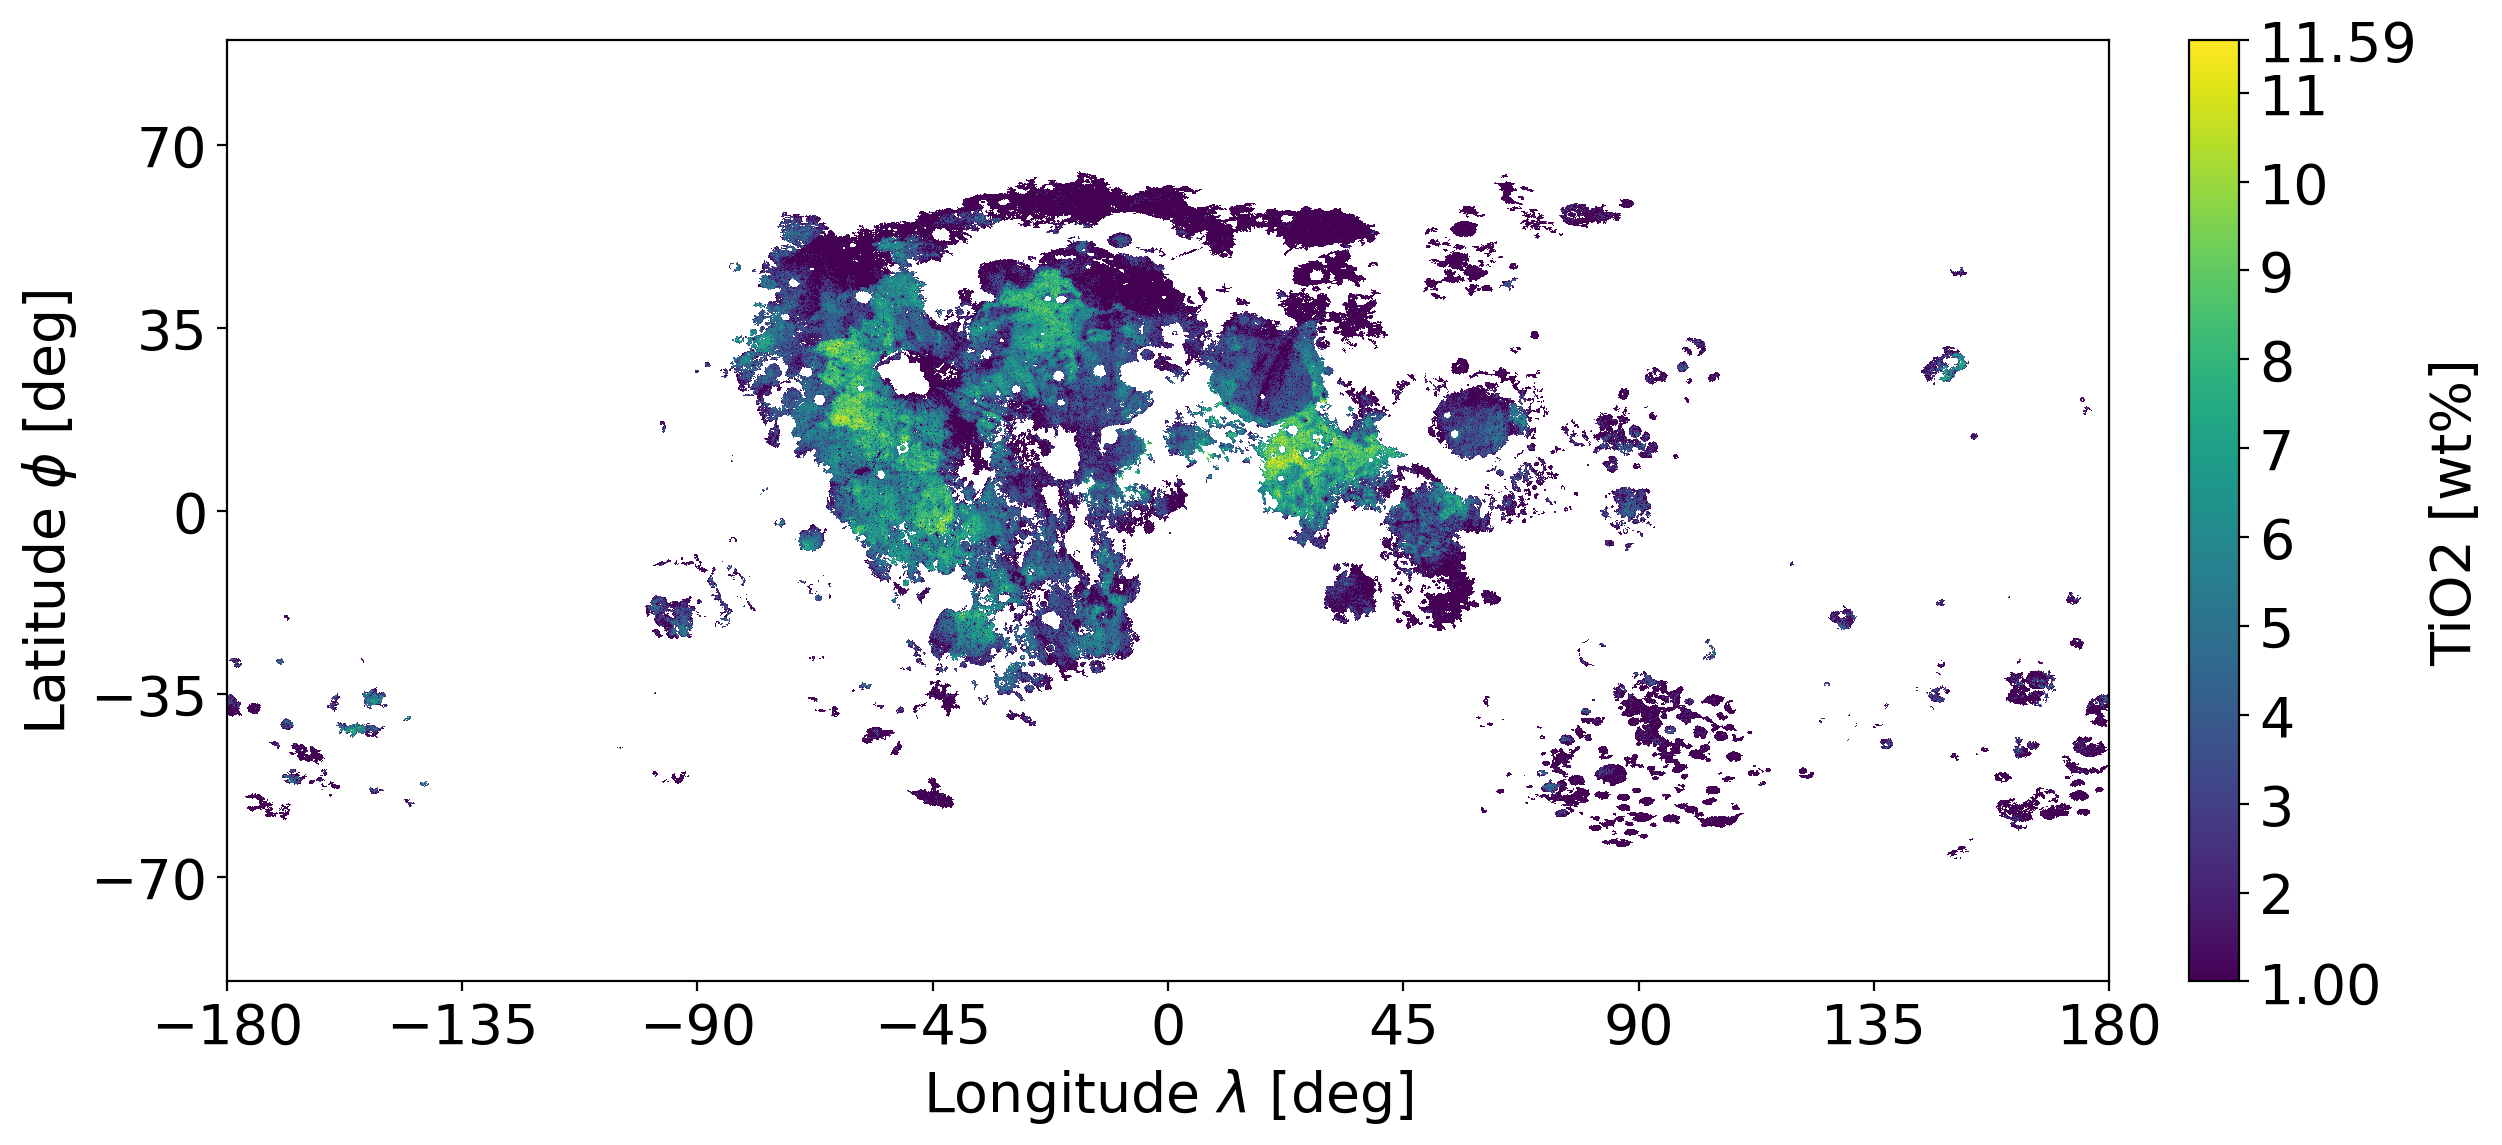

In [17]:
data = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_MARE.png"))
data = np.ma.masked_where(data == 0, data) # exclude values with zero
plot_map(data,22,'TiO2 [wt%]',(-70,70),(-180,180),y_limit=[-90,90],i_steps=(np.array([2,3,4,5,6,7,8,9,10,11])*divider).tolist(),cmap='viridis',silent=True)

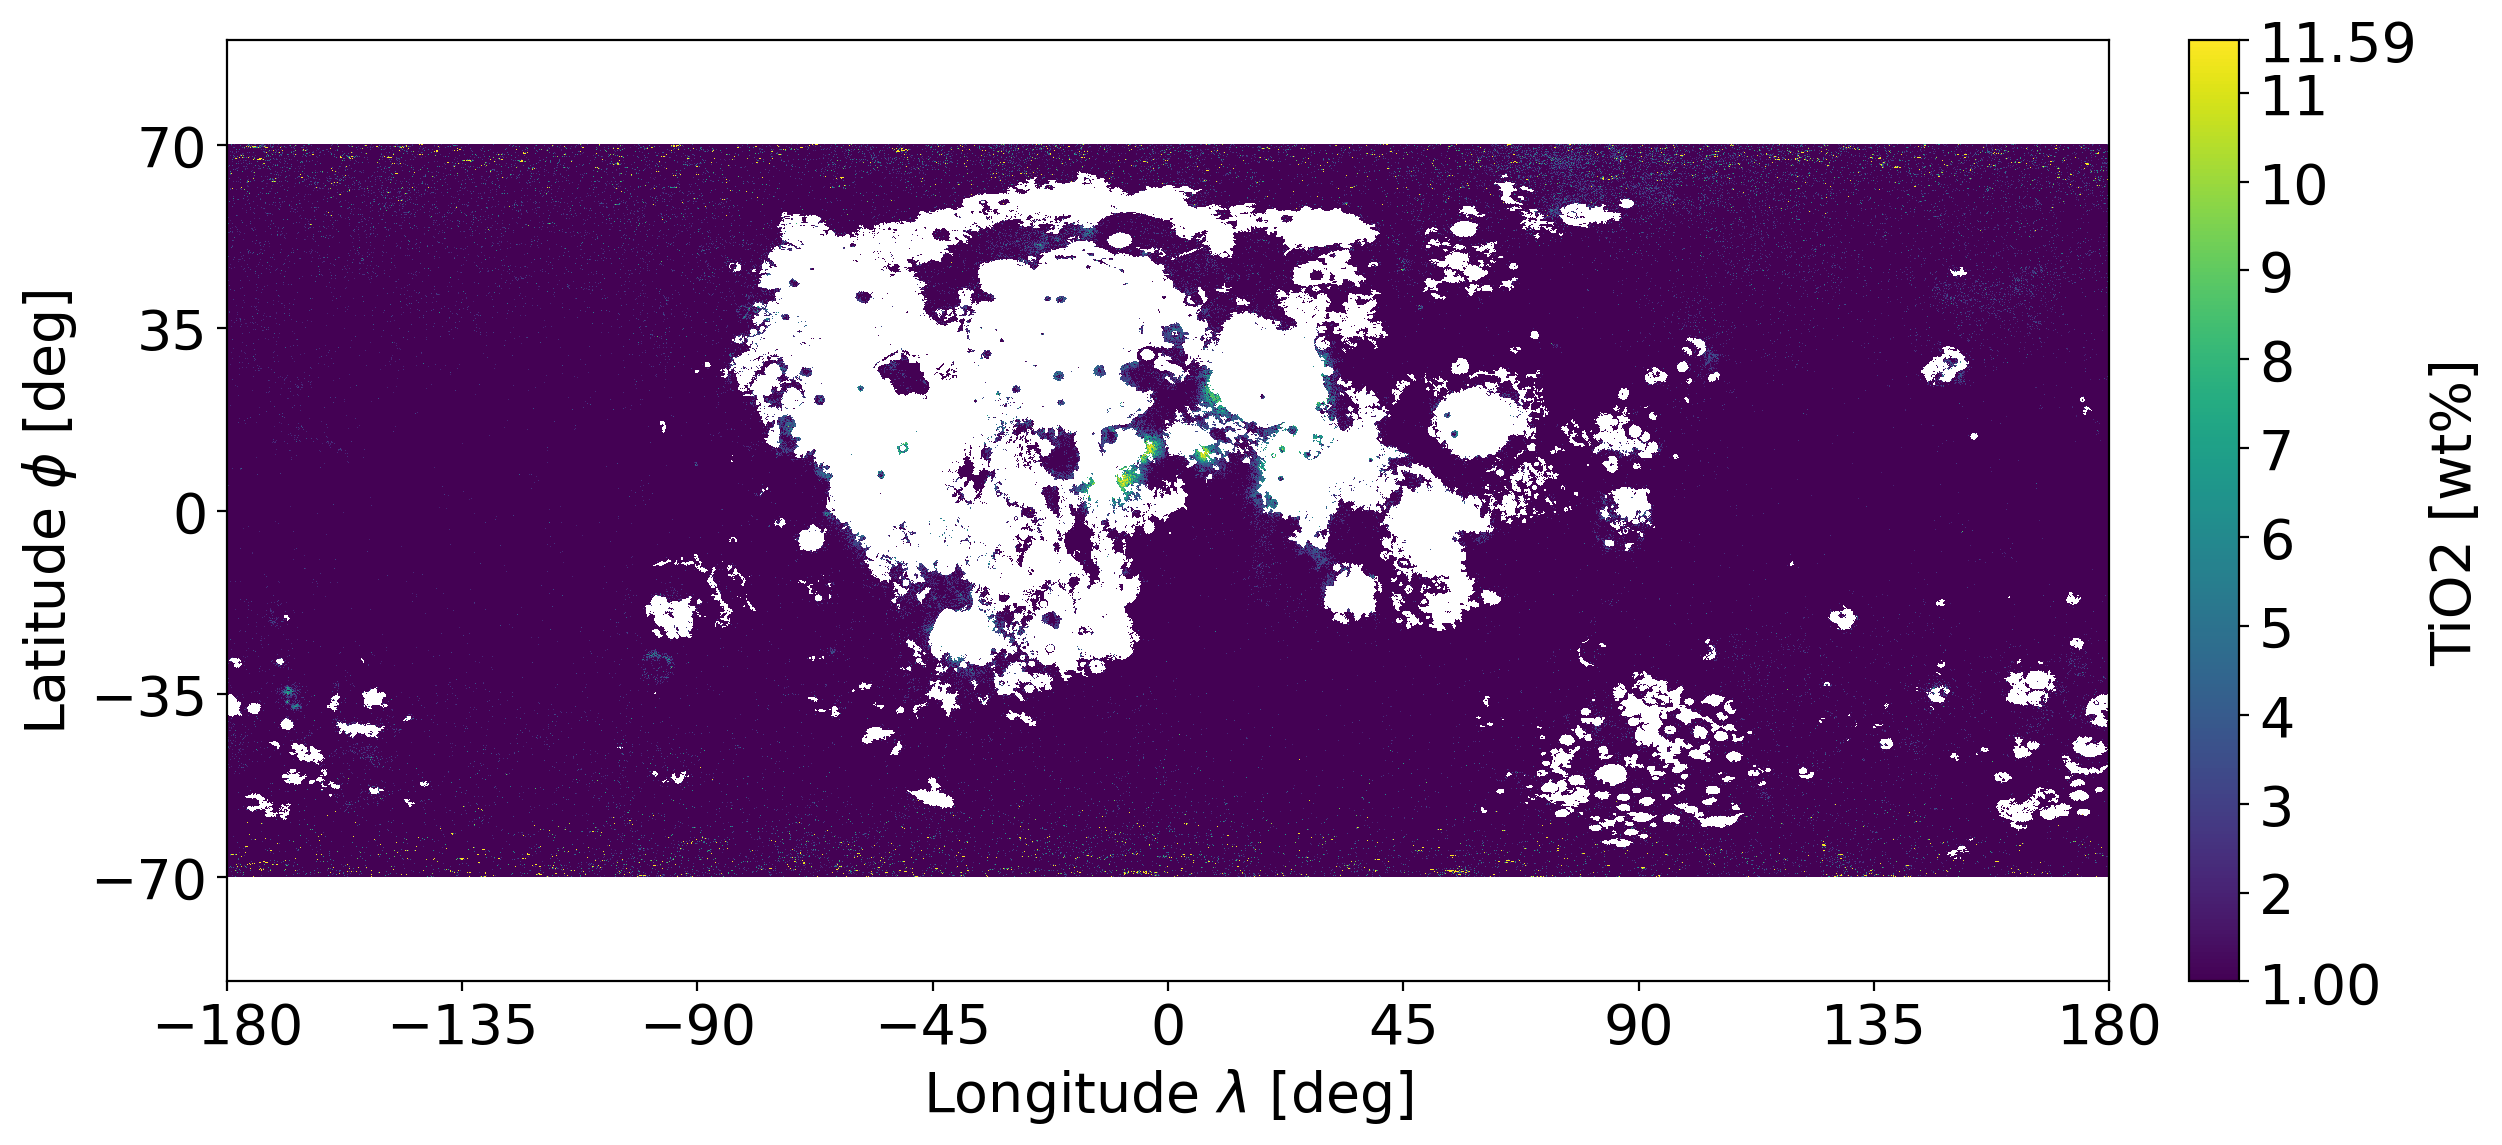

In [18]:
data = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_HIGH.png"))
data = np.ma.masked_where(data == 0, data) # exclude values with zero
plot_map(data,22,'TiO2 [wt%]',(-70,70),(-180,180),y_limit=[-90,90],i_steps=(np.array([2,3,4,5,6,7,8,9,10,11])*divider).tolist(),cmap='viridis',silent=True)

### Helper functions for histogram

In [19]:
# counteract Equirectangular projection by calculating back spherical shape
# weighted by changing radius -> circumference over Lat

r_moon = 1737400 # [m] volumetric mean 
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
# is used for readablity - will cancel out in weight calculation


def plot_histogram_compensate_Equirectangular(data,Lat_range,value_devider=None,drop_zeros=None,color=None,verify=None,save=None,label=None,dtype=np.uint8):
    
    size_dtype = np.iinfo(dtype).max + 1
    labelsize = 16
    print(data.shape)
    lines, line_length = data.shape
    
    Lat_min , Lat_max = Lat_range # centered Lat_range required
    Lat_coverage = Lat_max - Lat_min 
    Lat_coverage_p = Lat_coverage/180
    Lat_step = (Lat_max - Lat_min) / lines
    print(f'{Lat_coverage} Lat_coverage {Lat_coverage_p} and Lat_step of {Lat_step:0.4f}°')

    count_result = np.zeros(size_dtype)
    
    equator_circumference = 2 * np.pi * r_moon
    
    for i in range(lines):
        
        line_Lat = Lat_max - i*(Lat_step) -0.5*Lat_step
        #print(line_Lat)
        
        # counting each line
        line_count = np.bincount(data[i])
        
        # compute weight for line by (circumference at position / equatorial circumference)
        dist_from_eq_px = 0.5 - ((lines/2) - i)
        unit_dist_from_eq = dist_from_eq_px / (lines/2) # 
        
        i_circumference = 2 * np.pi * (np.cos(np.deg2rad(line_Lat)) * r_moon)
        
        w = i_circumference / equator_circumference
        
        # add to stacked weighted countd
        for index, d in enumerate(line_count):
            count_result[index] += d * w
    
    
    if drop_zeros: count_result[0]=0
    
    # probability
    probability_result = np.zeros(size_dtype)
    count_sum = np.sum(count_result)
    
    for index, d in enumerate(count_result):
        probability_result[index] = count_result[index] / count_sum
    
    if verify: 
        print('Earths landmass probability',probability_result[0],'correct value', 0.292)
        return
    
    x = probability_result
    x = x.flatten()
    
    if drop_zeros: 
        avg = np.mean(data[data != 0])
    else:
        avg = np.mean(data)

    print("Equirectangular Average",avg)
    
    total_sum = 0
    for index, d in enumerate(count_result):
        total_sum += d * index
    
    avg = total_sum / np.sum(count_result)
    print("Equi. corrected Average",avg, '=',avg/value_devider,'wt% TiO2')

    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gainsboro')
    plt.bar(range(256), x,color = color, lw=0, width=1.0, label=label)
    plt.legend(loc="upper right",fontsize=labelsize)
    plt.ylabel('Probability',fontsize=labelsize)
    plt.xlabel('TiO2 [wt%]',fontsize=labelsize)
    plt.yscale('log')
    if not verify: plt.ylim(0.4*10e-6,1.2)
    if value_devider: plt.xticks(np.append(np.arange(0, 256, value_devider), 264))
    plt.draw()
    labels = [item for item in ax.get_xticks()]
    converted_value_labels = []

    for i in labels:
        converted_value_labels.append(i/value_devider)

    #converted_value_labels = np.append(np.arange(min_value/value_devider, max_value/value_devider, 1), max_value/value_devider)
    labels = converted_value_labels

    formatted_labels = []
    for i , x in enumerate(labels):
        formatted_labels.append('{:.0f}'.format(x))

    ax.xaxis.set_ticklabels(formatted_labels)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
    
    if save: plt.savefig("doc/img/" + save, bbox_inches='tight', dpi=500)
    plt.show()
    plt.close()

verifying equirectangular correction by Earths landmass


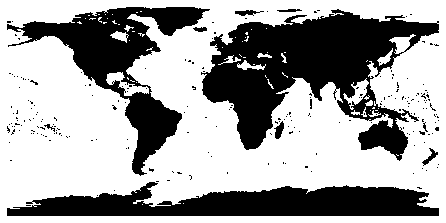

(14491, 30000)
180 Lat_coverage 1.0 and Lat_step of 0.0124°
Earths landmass probability 0.28143257921655473 correct value 0.292


In [20]:
# verify plot_histogram_compensate_Equirectangular function by landmass percentage of earth
print("verifying equirectangular correction by Earths landmass")
# create eath png
#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = geopandas.read_file("maps\preparation\TiO2\Earth/ne_10m_land.shp")
world.plot(color="Black", antialiased=False)
plt.axis('off')
# remove all whitespace padding around canvas
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('maps\preparation\TiO2\Earth_verify.png', dpi=5000,facecolor ='white', bbox_inches='tight',pad_inches = 0)
plt.show()
plt.close()
# convert image to Luminance 8 bit
im = Image.open("maps\preparation\TiO2\Earth_verify.png").convert('L')
im.save('maps\preparation\TiO2\Earth_verify.png')
# test "plot_histogram_compensate_Equirectangular()" on earth landmass
x = np.array(Image.open("maps\preparation\TiO2\Earth_verify.png"))
plot_histogram_compensate_Equirectangular(x,tuple((-90,90)), drop_zeros=False,color="darkcyan",verify=True)
# correct value 0.292
# http://www.physicalgeography.net/fundamentals/8o.html
# remaining error unknown: probably caused by nonspherical earth 

### plot distribution of clustered areas: Mare | Highlands

(10640, 27360)
140 Lat_coverage 0.7777777777777778 and Lat_step of 0.0132°
Equirectangular Average 72.64976638886758
Equi. corrected Average 76.39908263214468 = 3.472685574188395 wt% TiO2


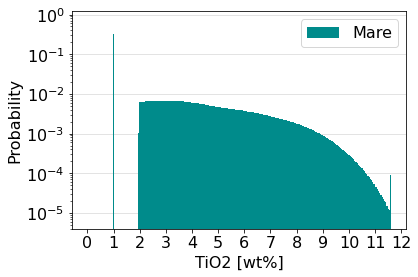

(10640, 27360)
140 Lat_coverage 0.7777777777777778 and Lat_step of 0.0132°
Equirectangular Average 24.38450820425185
Equi. corrected Average 24.133115689903484 = 1.096959804086522 wt% TiO2


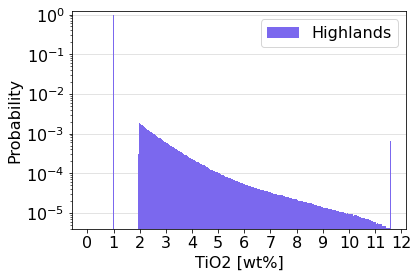

In [22]:
# distribution of result clustering
x = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_MARE.png"))
plot_histogram_compensate_Equirectangular(x,tuple((-70,70)),value_devider=22,label='Mare', drop_zeros=True, color="darkcyan", save="WAC_TIO2_DIST_MARE.pdf")

x = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_HIGH.png"))
plot_histogram_compensate_Equirectangular(x,tuple((-70,70)),value_devider=22,label='Highlands', drop_zeros=True, color="mediumslateblue", save="WAC_TIO2_DIST_HIGH.pdf")

### create mask: Mare boundaries & Latitude cut ±56°

In [23]:
# load mare boundaries mask
mare_mask = Image.open('maps\preparation\TiO2\LROC_GLOBAL_MARE_180_WAC_MASK.png')

# creating a rectangle image to place on the mare_mask
# 70° -> 10640 / 2 = 5320 px
# 56° -> 4256 px
# +/-56° -> 8512 px
# Luminance mode and size 8512 x 27360
im_rect = Image.new(mode="L",  size=(27360,8512),color=255)

# place im_rect on mask
# offset 5320 - 4256 = 1064
mare_mask.paste(im_rect, (0, 1064))

print('saving...')
mare_mask.save('maps/preparation/TiO2/LROC_GLOBAL_MARE_180_WAC_MASK_EXTENDED.png')

print("creating NEG version...")
im = Image.open("maps/preparation/TiO2/LROC_GLOBAL_MARE_180_WAC_MASK_EXTENDED.png")
im_invert = ImageOps.invert(im)
im_invert.save('maps/preparation/TiO2/LROC_GLOBAL_MARE_180_WAC_MASK_EXTENDED_NEG.png')
print('done.')

saving...
creating NEG version...
done.


### plot mask for figure

display values (27360, 10640)
extrema 0 255


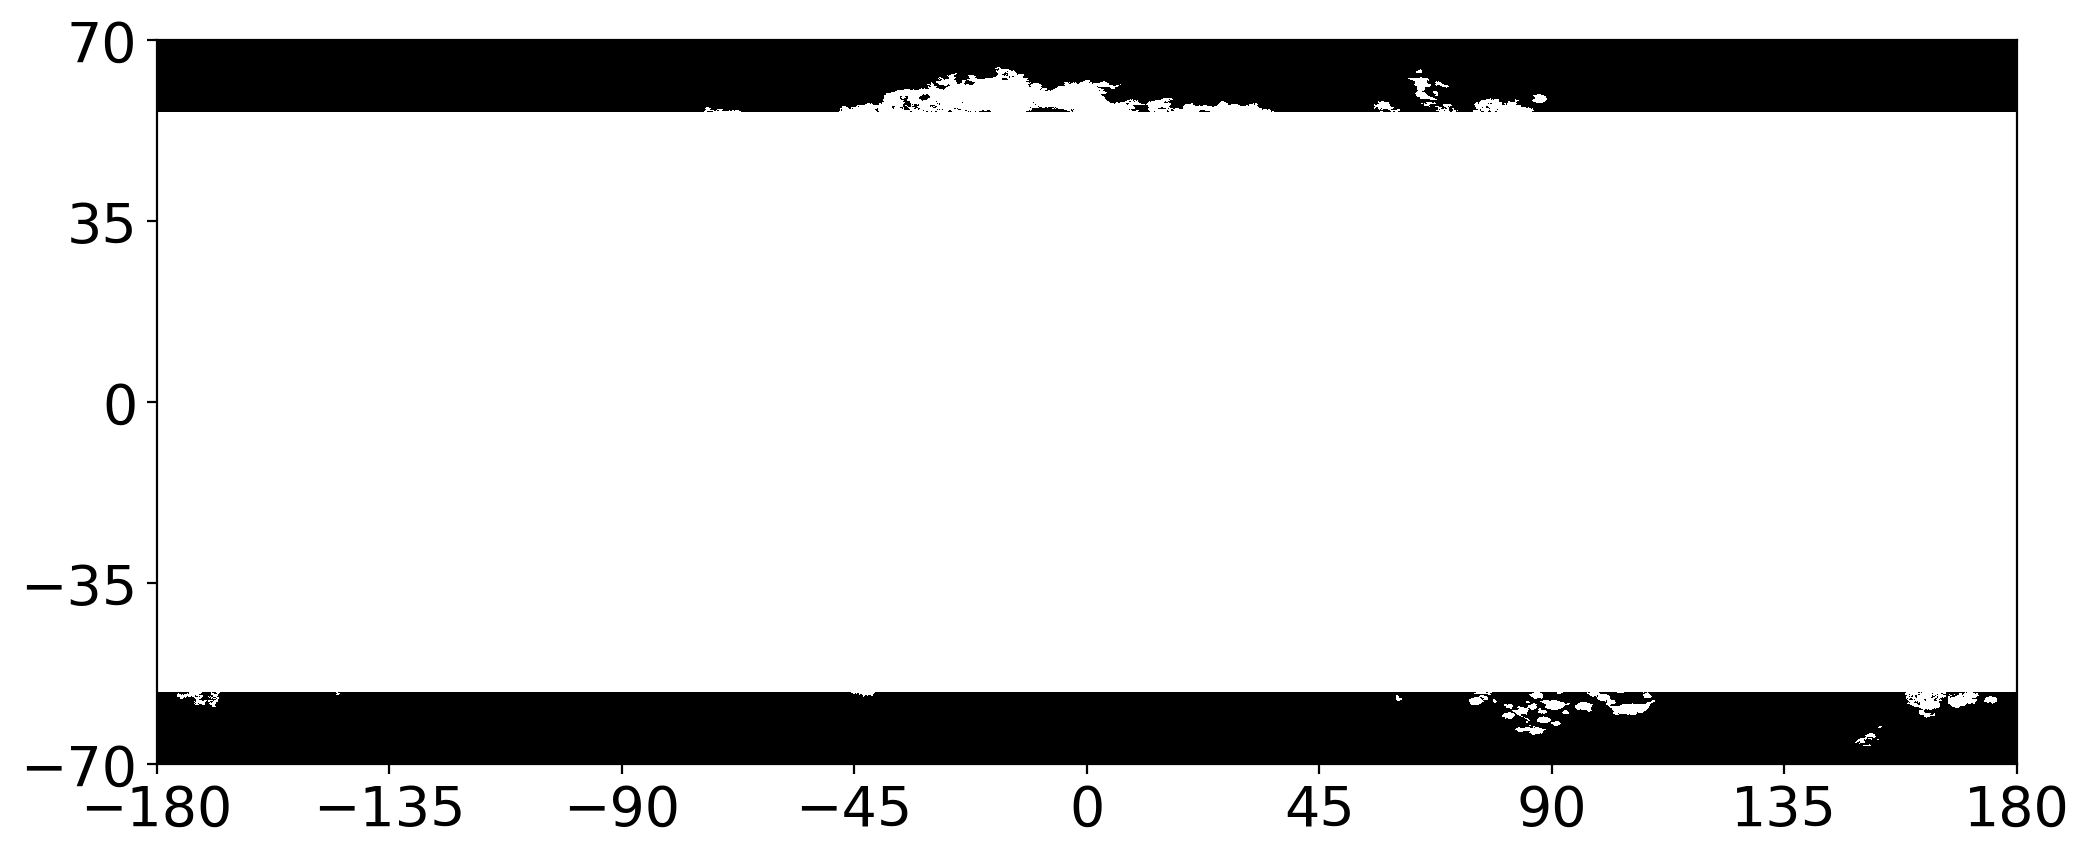

In [27]:
data = np.array(Image.open('maps/preparation/TiO2/LROC_GLOBAL_MARE_180_WAC_MASK_EXTENDED.png'))
plot_map(data,1,'',(-70,70),(-180,180),labelsize=20,save="LROC_GLOBAL_MARE_180_WAC_MASK_EXTENDED.png",bw=True,cmap='gray')

### apply mask and fill in Highlands and Poles with lower bound

In [28]:
image = cv2.imread('maps/preparation/TiO2/WAC_TIO2_COMBINED.png',0)

mask = cv2.imread('maps/preparation/TiO2/LROC_GLOBAL_MARE_180_WAC_MASK_EXTENDED.png',0)
#mask_hand = cv2.imread('LROC_GLOBAL_MARE_180_WAC_MASK_HAND.png',0)
mask_neg = cv2.imread('maps/preparation/TiO2/LROC_GLOBAL_MARE_180_WAC_MASK_EXTENDED_NEG.png',0)

result = cv2.bitwise_and(image, mask)
result[mask==0] = 22 # set background to 1 w%

result_omit = cv2.bitwise_and(image, mask_neg)
result_omit[result<22] = 255 # mark what will be set to 1 w% from below 1 w%

result[result<22] = 22 # set everything below 1% to 1 w%


#result_hand = cv2.bitwise_and(image, mask_hand)
#result_hand[mask_hand==0] = 22 # set background to 1 w%
#result_hand[result_hand<22] = 22 # set everything below 1% to 1 w%


cv2.imwrite('maps/preparation/TiO2/WAC_TIO2_GLOBAL_MASKED.png', result)
#cv2.imwrite('WAC_TIO2_GLOBAL_MASKED_MAP_HAND.png', result_hand)
cv2.imwrite('maps/preparation/TiO2/WAC_TIO2_GLOBAL_MASKED_OMITTED.png', result_omit)

print('mask applied.')

mask applied.


### plot omitted values

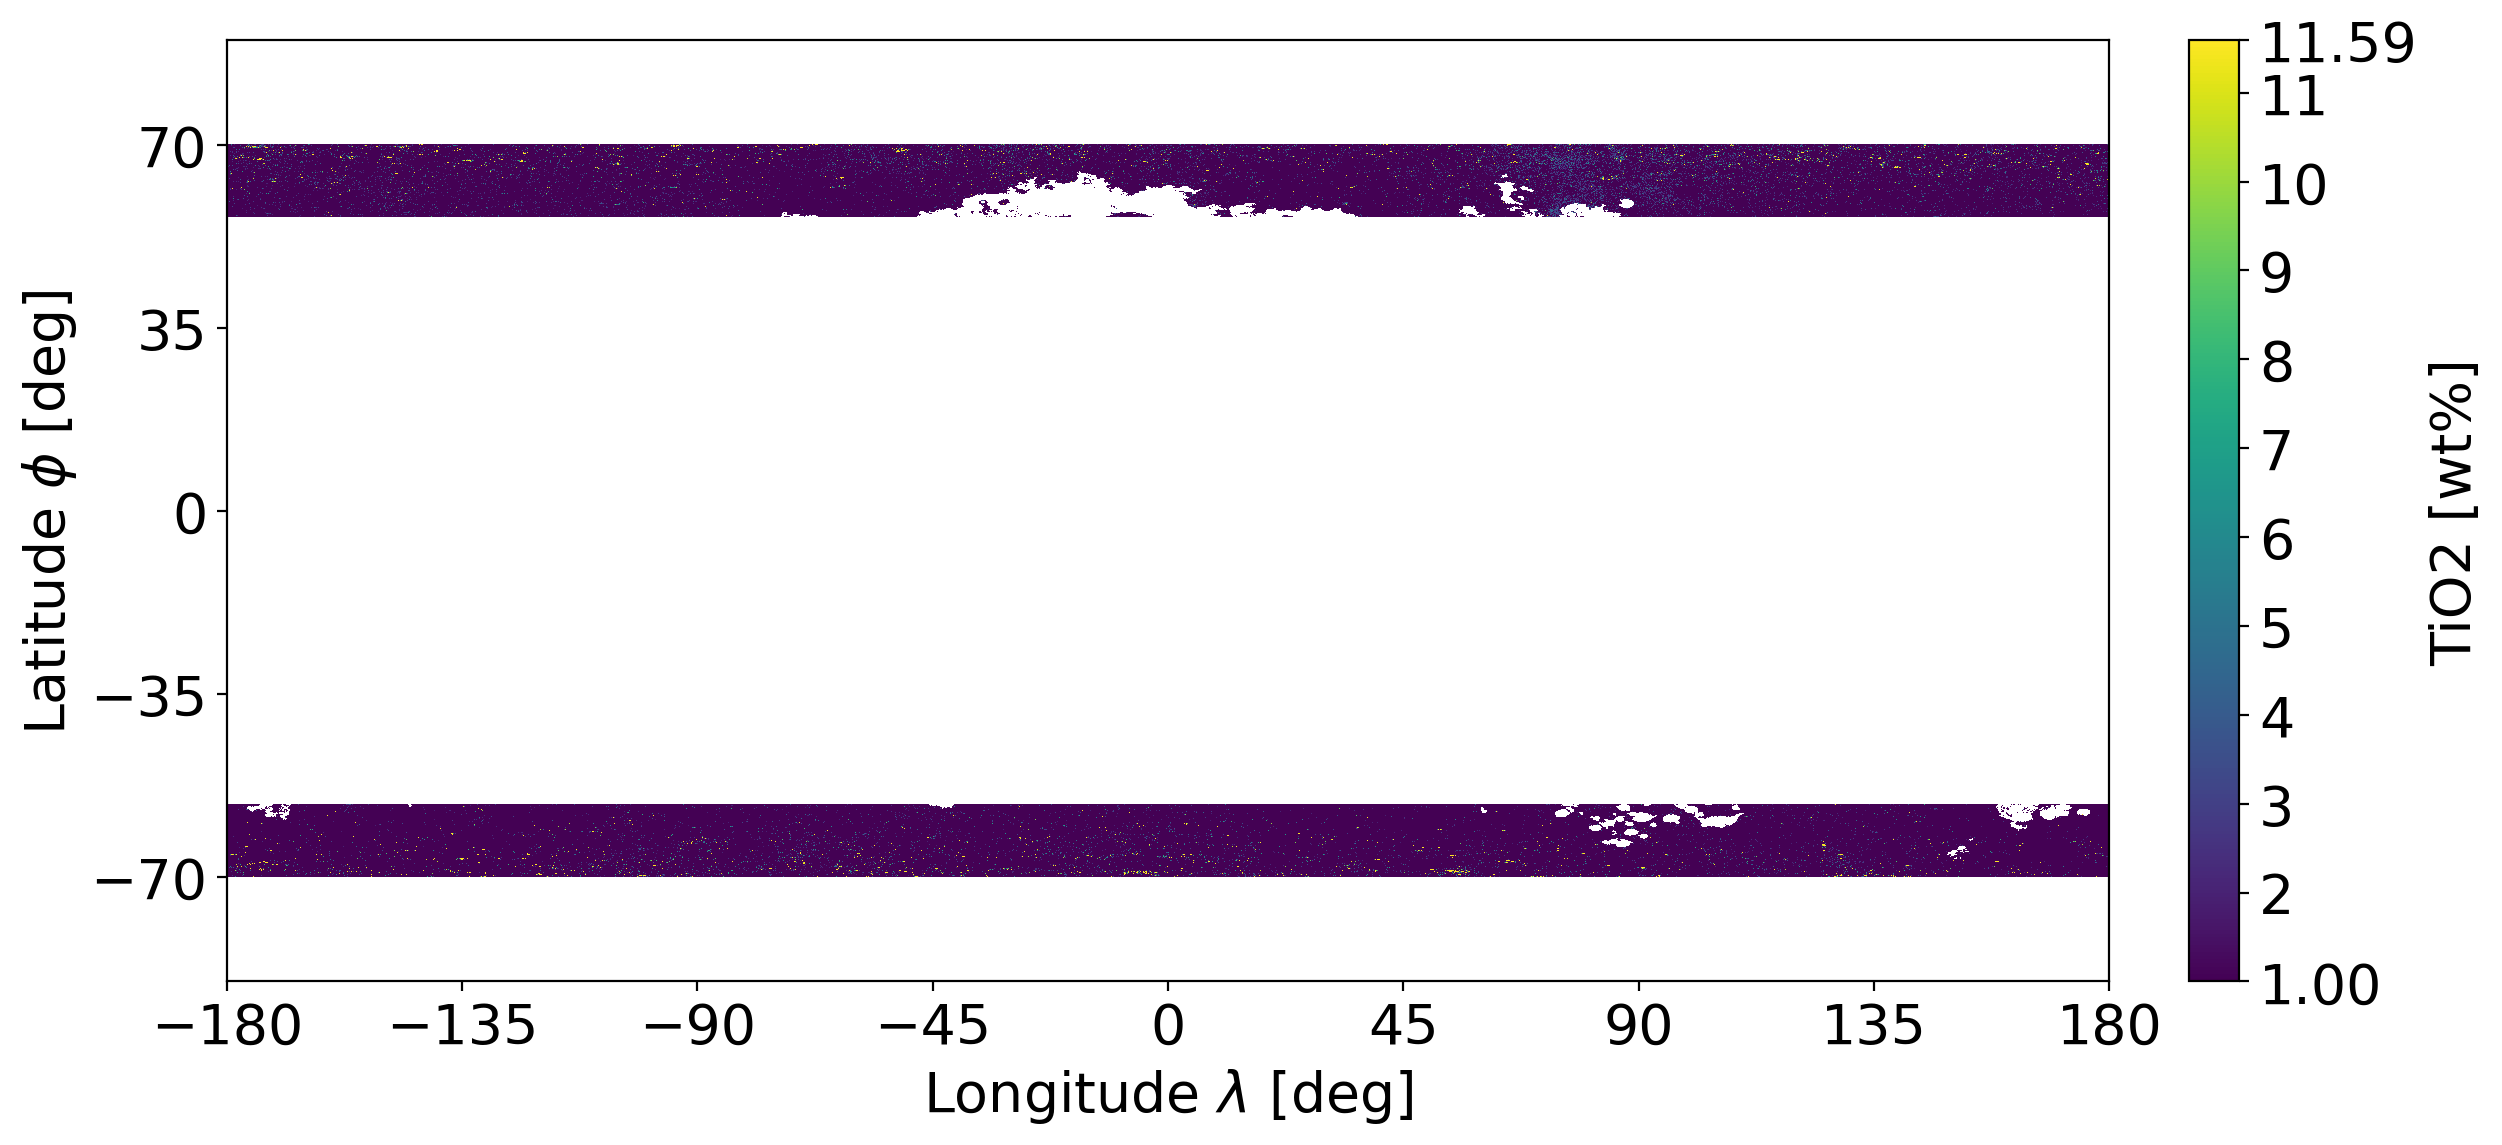

In [29]:
data = np.array(Image.open("maps\preparation\TiO2\WAC_TIO2_GLOBAL_MASKED_OMITTED.png"))
data = np.ma.masked_where(data == 0, data) # exclude values with zero
plot_map(data,22,'TiO2 [wt%]',(-70,70),(-180,180),y_limit=[-90,90],i_steps=(np.array([2,3,4,5,6,7,8,9,10,11])*divider).tolist(),cmap='viridis',silent=True)

In [30]:
# place map in global space and fill with estimate for poles

image = Image.open('maps/preparation/TiO2/WAC_TIO2_GLOBAL_MASKED.png')

width, height = image.size
print("width",width,end=" ")
print("height",height,end=" ")

aspect_ratio = width/height
print("aspect_ratio",aspect_ratio)
if aspect_ratio == 2:
    print("aspect ratio already matching.")
    exit(0)
else:
    print("adapting aspect ratio to 2")

if aspect_ratio < 2:
    print("Expanding width")
    print("ERROR:   Not implemented.")
    exit(0)

if aspect_ratio > 2:
    new_height = width/2
    if ((int(new_height) - height)% 2) == 0 :
        new_height = int(new_height)
    else:
        new_height = int(new_height)+1
    print("Expanding height to",new_height)
    add_lines = (new_height-height)/2
    print("adding",add_lines,"lines to the top and bottom")


    new_im = Image.new('L', (width, new_height),22)
    x_offset = 0
    y_offset = int(add_lines)
    new_im.paste(image, (x_offset,y_offset))

    new_im.save('maps/WAC_TIO2_GLOBAL.png')
    #new_im.save('WAC_TIO2_GLOBAL_MAP.TIF')
    print('COMPLETED.')

width 27360 height 10640 aspect_ratio 2.5714285714285716
adapting aspect ratio to 2
Expanding height to 13680
adding 1520.0 lines to the top and bottom
COMPLETED.


### plotting result Ilmenite map for paper Figure

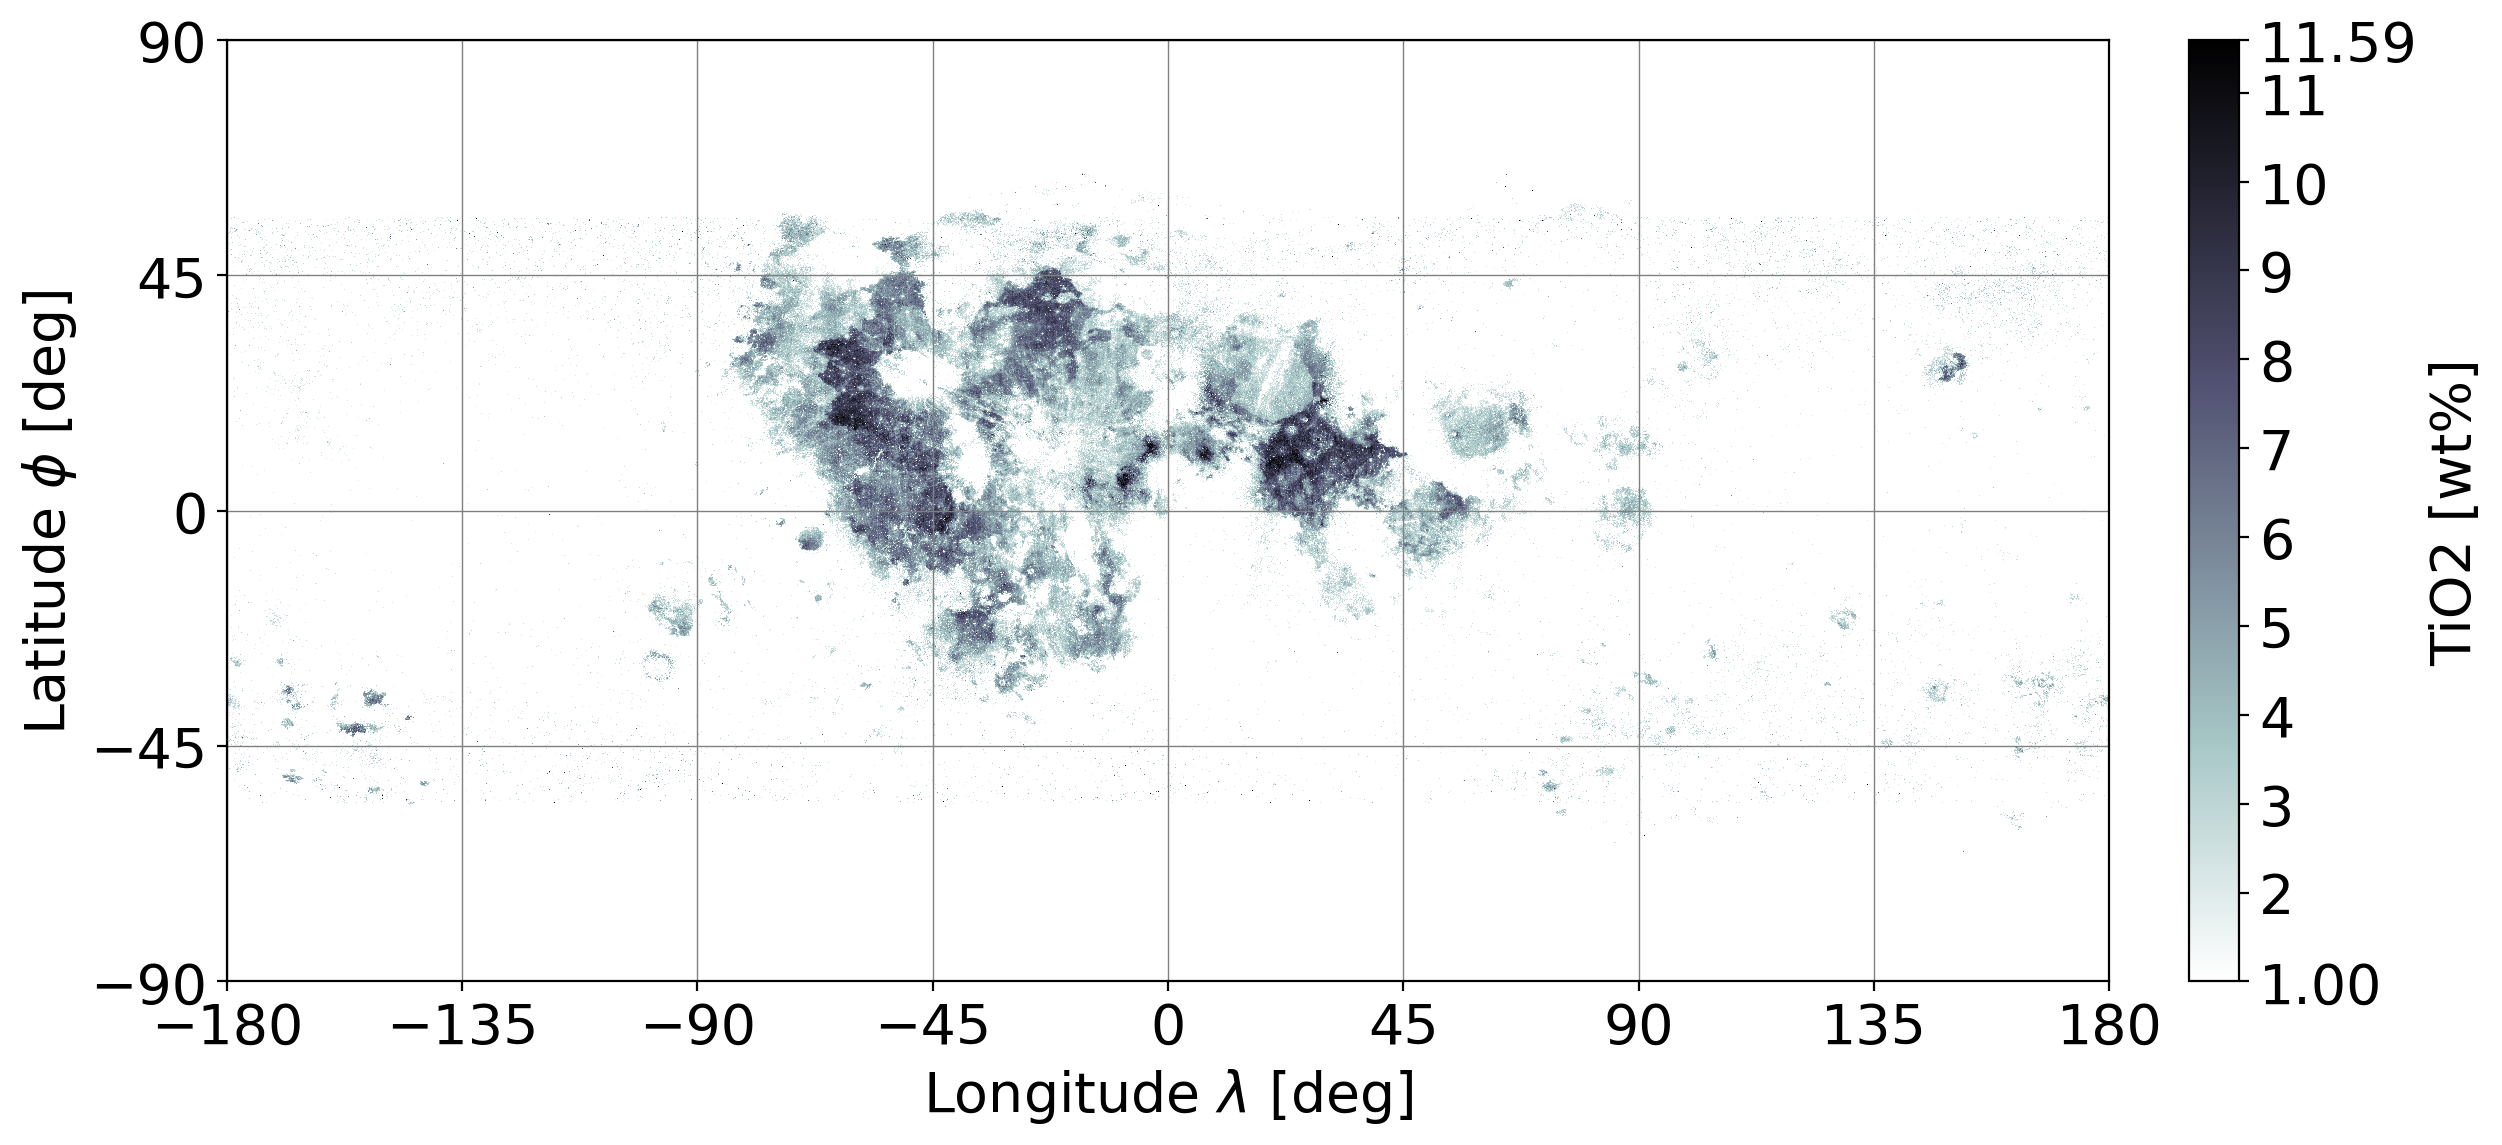

In [4]:
data = cv2.resize(np.array(Image.open("maps/WAC_TIO2_GLOBAL.png")), dsize=(5000,2500), interpolation=cv2.INTER_NEAREST)
plot_map(data,22,'TiO2 [wt%]',(-90,90),(-180,180),labelsize=20,i_steps=(np.array([2,3,4,5,6,7,8,9,10,11])*divider).tolist(),silent=True,cmap=bone.reversed(),interpolation='none',save="WAC_TIO2_GLOBAL.pdf")

## Global cost map

In [ ]:
print("1 wt%",ISRU_mass(1),"kg")
print("2 wt%",ISRU_mass(2),"kg")
print("11.59 wt%",ISRU_mass(11.59),"kg")

# determine dtype
# input  [      1   ..    11.59 ] 
# output [ 157718.5 .. 17055.765]
# zero digit precision - no float
# hold result in uint32
# save result in -> uint16 for storage benefits

### compute ISRU mass globally

In [ ]:
####################################################################################
# WARNING !    this step uses all available RAM and takes approx. 2 min to compute #
####################################################################################
data = np.array(Image.open('maps/WAC_TIO2_GLOBAL.png'))
ISRU_mass_result = ISRU_mass((data.astype(np.float64)/22))
print('64-bit float result computed')

In [ ]:
# cutting of precision to save on filesize
print(f'from  {ISRU_mass_result.dtype} {type(ISRU_mass_result)} {ISRU_mass_result.dtype.itemsize*ISRU_mass_result.shape[0]*ISRU_mass_result.shape[1]/(1024*1024*1024):0.2f} GB   {np.min(ISRU_mass_result)} - {np.max(ISRU_mass_result)}')
ISRU_mass_result_32bit = ISRU_mass_result.astype(np.float32, copy=False)
print(f'to    {ISRU_mass_result_32bit.dtype} {type(ISRU_mass_result_32bit)} {ISRU_mass_result_32bit.dtype.itemsize*ISRU_mass_result_32bit.shape[0]*ISRU_mass_result_32bit.shape[1]/(1024*1024*1024):0.2f} GB   {np.min(ISRU_mass_result_32bit)} - {np.max(ISRU_mass_result_32bit)}')

In [ ]:
# save data in xArray to file (~1.4 GB of space)

Lat = np.zeros(ISRU_mass_result_32bit.shape[0])
for i in range(ISRU_mass_result_32bit.shape[0]):
    Lat[i] = 90 - i * 180/len(Lat) - 0.5* 180/len(Lat)
    
Lon = np.zeros(ISRU_mass_result_32bit.shape[1])
for i in range(ISRU_mass_result_32bit.shape[1]):
    Lon[i] = 180 - i * 180/len(Lon) - 0.5* 180/len(Lon)
Lon = np.flip(Lon) 

xA_ISRU_mass_result_32bit = xr.DataArray(
    data=ISRU_mass_result_32bit,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Lon),
        lat=(["lat"], Lat)
    ),
    attrs=dict(
        description="ISRU mass costs for demo factory",
        var_desc="mass",
        units="kg",
    ),
)

xA_ISRU_mass_result_32bit.to_netcdf("maps/ISRU_COST_GLOBAL.nc")

### compress 64-bit result into 16-bit image

In [ ]:
# saving result as int64 xArray would take up 1.4 GB of space
# >> compress 64-bit result into 16-bit image ~74 MB

max_data_value = np.max(ISRU_mass_result)
min_value = 0
print('float64 result','min',np.min(ISRU_mass_result),'max',np.max(ISRU_mass_result))

# 16-bit maximum: 65535
# to fit max_data_value = 65535 = 16-bit maximum
value_scale_uint16 = max_data_value / 65535

data_result_unit16 = ISRU_mass_result / value_scale_uint16

print('unit16  result','min',np.min(data_result_unit16),'max',np.max(data_result_unit16), 'value_scale',value_scale_uint16)

# value_scale   = 2.4066300450141145
# value_devider = 1/2.4066300450141145

im_result = Image.fromarray(data_result_unit16.astype(np.uint16)).convert('I')

print('saving image...')
im_result.save("maps\ISRU_COST_GLOBAL.png")
print('completed.')

### plot global cost for paper figure

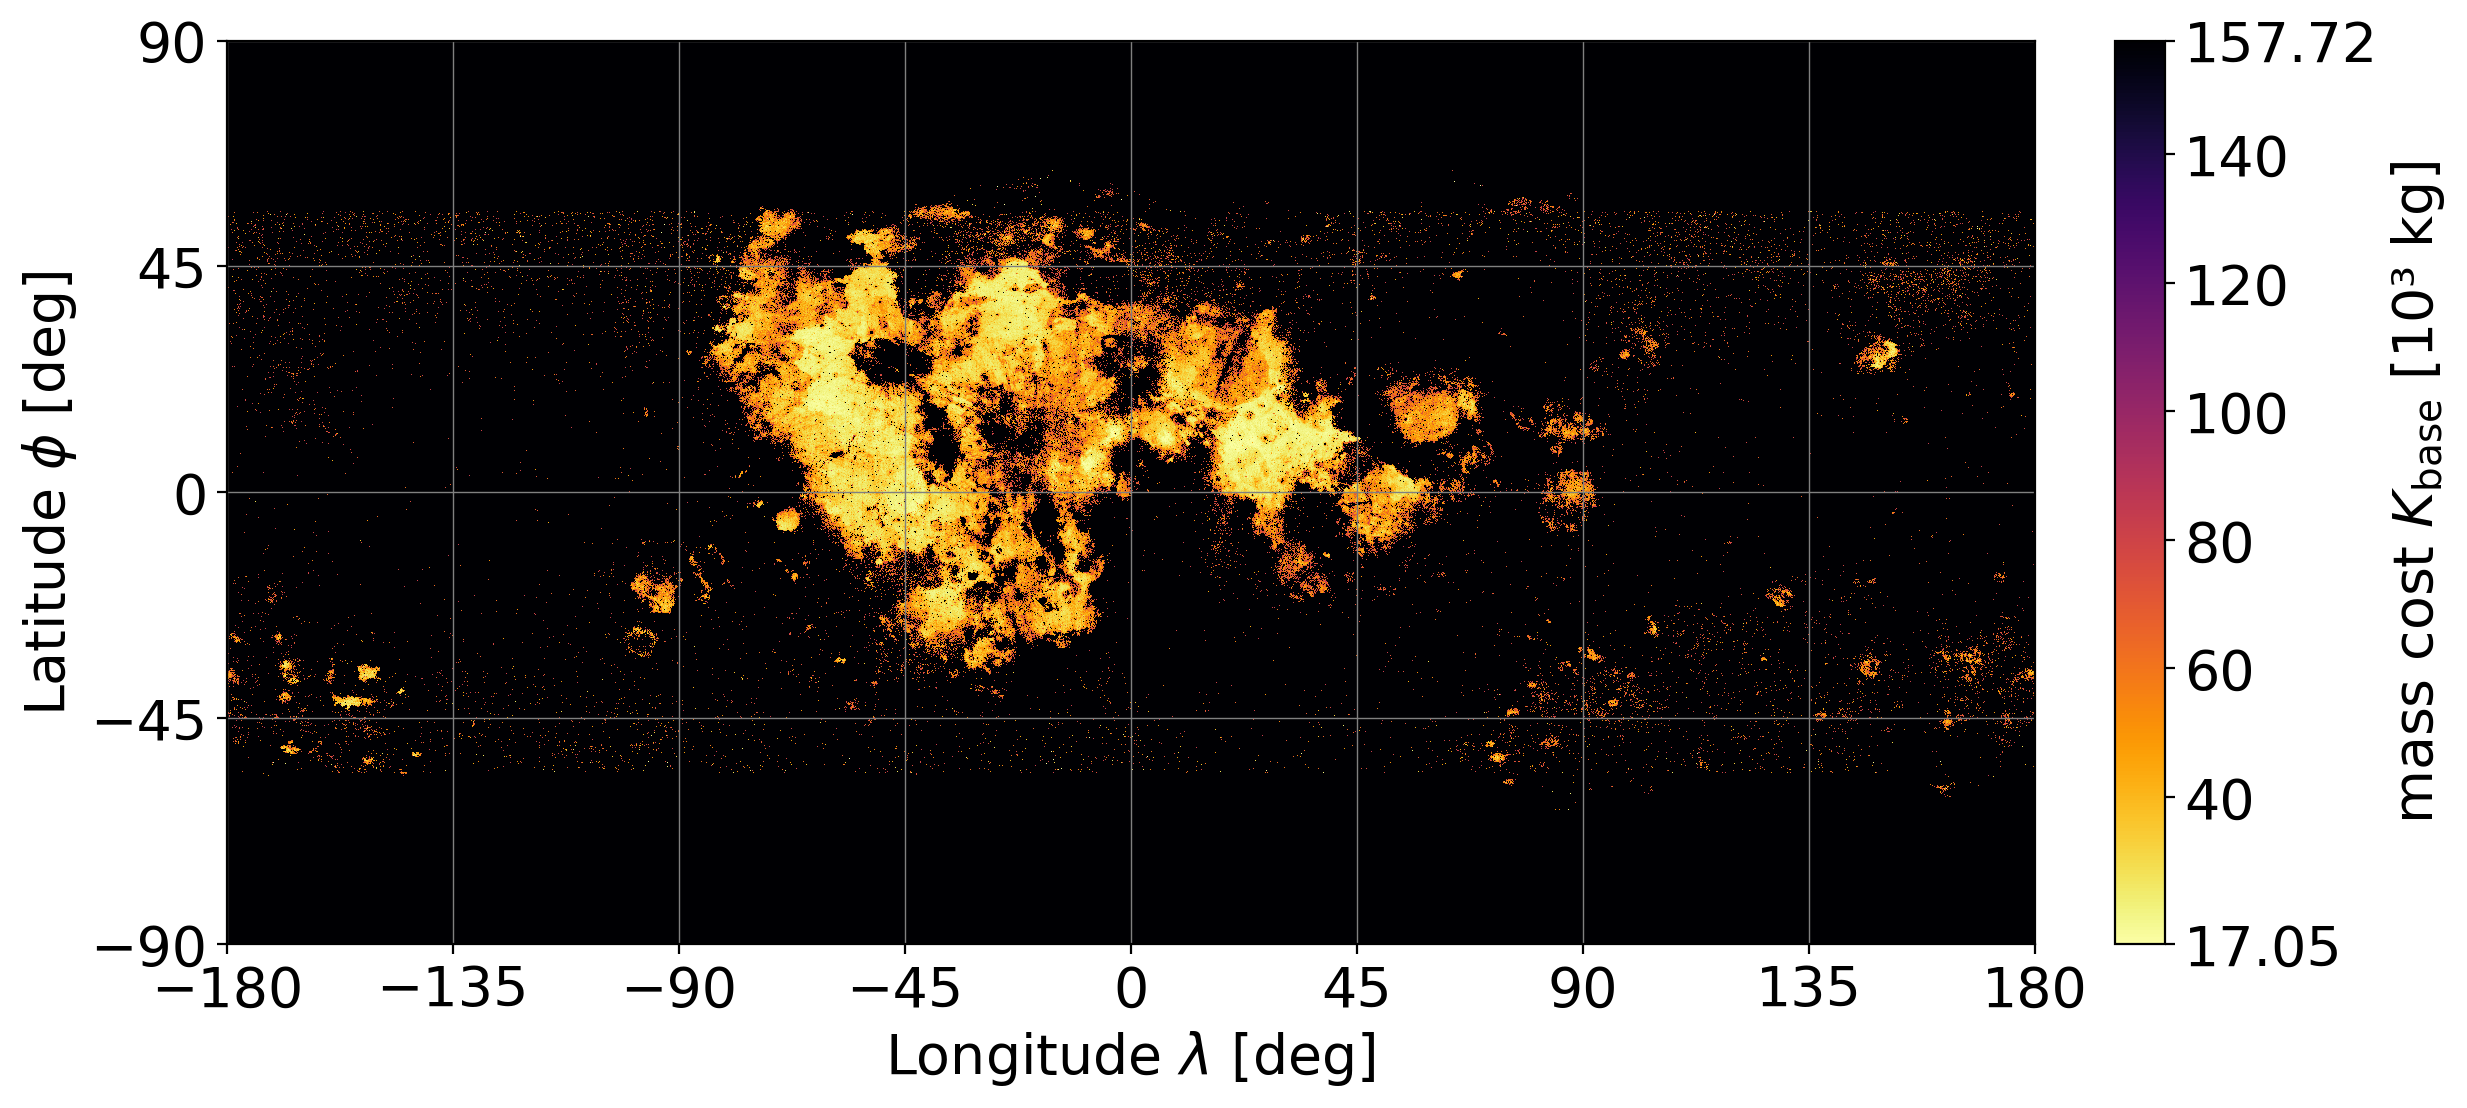

In [5]:
data = cv2.resize(np.array(Image.open("maps\ISRU_COST_GLOBAL.png")), dsize=(5000,2500), interpolation=cv2.INTER_NEAREST)
divider = 1000/2.4066300450141145
plot_map(data,divider,'mass cost $K_{\mathrm{base}}$ [10³ kg]',tuple((-90,90)),tuple((-180,180)),silent=True,cmap=inferno.reversed(),i_steps=(np.array([40,60,80,100,120,140])*divider).tolist(),labelsize=20,save="ISRU_COST_GLOBAL.pdf")